In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from time import time
import cv2

import scipy.sparse as ss

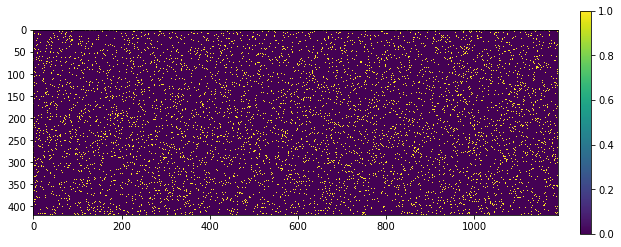

In [4]:
def r_s(h=420,w=1190,d=.06):
    return ss.random(h, w, density=d, format='csr',
                 data_rvs=np.ones,   # fill with ones
                 dtype='f'           # use float32 first
                 ).toarray()

img_bead_gt = np.stack((r_s(), r_s(), r_s(), r_s(), r_s(), r_s(), r_s(), r_s())) # batch=8
img_bead_gt = torch.FloatTensor(img_bead_gt).to('cuda')
img_bead_gt = img_bead_gt.unsqueeze(1) # [4, 420, 1190] -> [4, 1, 420, 1190]

plt.figure(figsize=(10,10))
plt.imshow(img_bead_gt[0,0,:,:].detach().cpu().numpy())
plt.colorbar(fraction=0.02, pad=0.04)

In [2]:
psf_map_6x17 = np.load('../220624_SV_3D_Forward/psf_2d_6x17_0514_thres270.npy')
print(psf_map_6x17.shape)

(6, 17, 41, 41)


In [3]:
class SVConv2d_one_channel(nn.Module):
    def __init__(self, kernel_size, kH=4, kW=10, initialize=None):
        '''
        in_channels, out_channels = 1,
        kH, kW: number of kernels in height, width (default 4x10)
        '''
        super().__init__()
        self.ks = kernel_size
        self.kH = kH
        self.kW = kW
        
        if isinstance(initialize, (np.ndarray, torch.Tensor)):
            # psf_map [4, 10, 41, 41] -> [40, 1, 41, 41])
            self.SVconv = torch.nn.Conv2d(self.kH*self.kW, self.kH*self.kW, kernel_size, 
                                          groups=self.kH*self.kW, bias=False)
            self.SVconv.weight = torch.nn.Parameter(initialize.flatten(0,1).unsqueeze(1))
            
        else:
            self.SVconv = torch.nn.Conv2d(self.kH*self.kW, self.kH*self.kW, kernel_size, 
                                          groups=self.kH*self.kW, bias=False)
        
    def forward(self, x):
        B, C, H, W = x.shape
        pad_size = self.ks - 1
        pad_w, pad_h = pad_size, pad_size
        kernel = H//self.kH + pad_size   
        stride = H//self.kH    # stride < kernel will lead to overlap 

        x = F.pad(input=x, pad=(pad_w//2, pad_w-pad_w//2, # Padding the input (reflection pad vs zero pad)
                                pad_h//2, pad_h-pad_h//2), mode='constant', value=0)
        
        x = x.unfold(3,kernel,stride).unfold(2,kernel,stride).permute(0,1,2,3,5,4) # nn.Unfold to patch
        x = x.flatten(2,3).squeeze(1)
        
        # sv conv  # x = F.conv2d(x, self.SVkernel, groups=self.kH*self.kW)
        x = self.SVconv(x)
        
        x = x.flatten(2,3) # reshape output to match F.fold input
        x = x.permute(0,2,1) 
        x = F.fold(x, output_size=(H,W),
                   kernel_size=stride, stride=stride) # [4, 1, 420, 1190]
        return x

Time: 0.002002239227294922s
torch.Size([8, 1, 420, 1190])


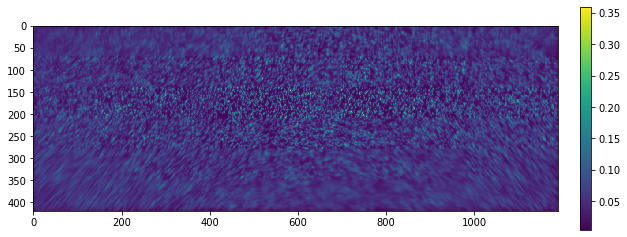

In [8]:
psf_map_6x17 = torch.FloatTensor(psf_map_6x17)
blur_module = SVConv2d_one_channel(kernel_size=41, kH=6, kW=17,initialize=psf_map_6x17).to("cuda")

t0 = time()
img_bead_blur = blur_module(img_bead_gt)
print("Time: {}s".format(time()-t0))
print(img_bead_blur.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_bead_blur[0,0,:,:].detach().cpu().numpy())
plt.colorbar(fraction=0.02, pad=0.04)

epoch    100    , loss: 84041.2734
epoch    200    , loss: 77221.1250
epoch    300    , loss: 72191.9844
epoch    400    , loss: 68032.8125
epoch    500    , loss: 64326.3750
epoch    600    , loss: 60887.2578
epoch    700    , loss: 57633.1562
epoch    800    , loss: 54527.0469
epoch    900    , loss: 51551.9453
epoch    1000   , loss: 48699.6016
epoch    1100   , loss: 45965.3750
epoch    1200   , loss: 43346.0273
epoch    1300   , loss: 40838.7812
epoch    1400   , loss: 38440.9766
epoch    1500   , loss: 36149.9258
epoch    1600   , loss: 33962.9141
epoch    1700   , loss: 31877.1602
epoch    1800   , loss: 29889.8555
epoch    1900   , loss: 27998.1602
epoch    2000   , loss: 26199.1992
epoch    2100   , loss: 24490.1055
epoch    2200   , loss: 22868.0039
epoch    2300   , loss: 21330.0234
epoch    2400   , loss: 19873.3105
epoch    2500   , loss: 18495.0312
epoch    2600   , loss: 17192.3730
epoch    2700   , loss: 15962.5527
epoch    2800   , loss: 14802.8193
epoch    2900   , lo

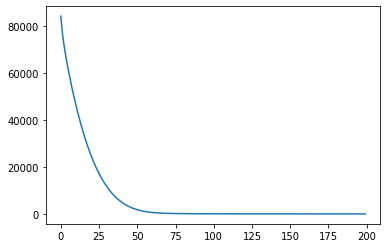

In [12]:
# Create Tensors to hold input and outputs.
x = img_bead_gt
y = img_bead_blur.detach().cuda() # detach solves problem

# Construct our model by instantiating the class defined above
model = SVConv2d_one_channel(kernel_size=21, kH=6, kW=17, initialize=None).to("cuda")

# Construct our loss function and an Optimizer. 
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_list = []

for t in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        loss_list.append(loss.item())
        print("epoch {:^{}d},   loss: {:^{}.4f}".format(t+1, 10, loss.item(), 10))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_list)

In [15]:
def plot_psf_map(psf_map):
    num_row = len(psf_map)
    num_col = len(psf_map[0])
    plt.figure(figsize=(1*num_col,1*num_row))

    for row_n in range(psf_map.shape[0]):
        for col_n in range(psf_map.shape[1]):
            plt.subplot(psf_map.shape[0], psf_map.shape[1], psf_map.shape[1]*row_n + col_n + 1)
            if len(psf_map[row_n][col_n].shape) ==3:            
                psf_mip = np.max(psf_map[row_n][col_n], axis=0)
                plt.imshow(psf_mip) # if 3D, plot MIP
            else:
                plt.imshow(psf_map[row_n][col_n])
            plt.axis('off')
    plt.tight_layout()

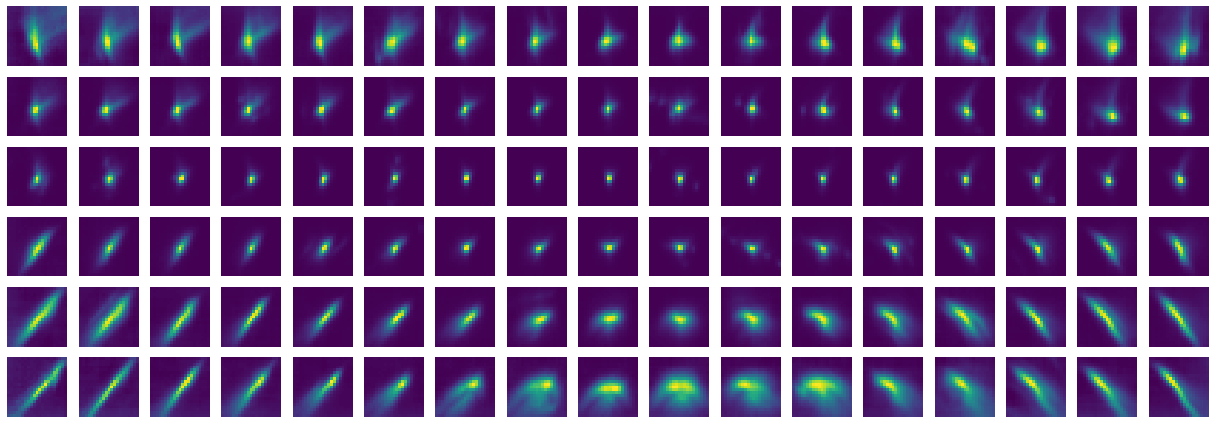

In [14]:
trained_psf = model.SVconv.weight.detach().cpu().numpy().squeeze()
trained_psf = trained_psf.reshape((6,17,21,21))
plot_psf_map(trained_psf)

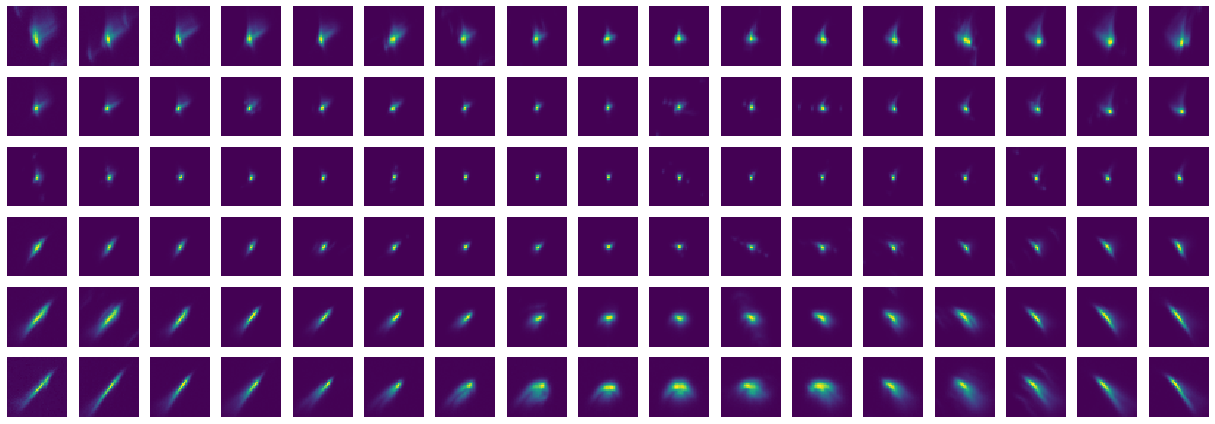

In [15]:
plot_psf_map(psf_map_6x17.detach().cpu().numpy())

## Does sum = 1 holds for trained psf?

In [20]:
np.sum(np.sum(trained_psf, axis=2), axis=2)

array([[0.95285857, 0.96828246, 0.97323793, 0.9779313 , 0.97852325,
        0.98309404, 0.9783162 , 0.98540044, 0.98936725, 0.9887222 ,
        0.9893029 , 0.98968434, 0.98699284, 0.985497  , 0.98775846,
        0.9819982 , 0.9745008 ],
       [0.98390675, 0.9929105 , 0.9934234 , 0.99220496, 0.9946816 ,
        0.9937558 , 0.99498504, 0.99657345, 0.9958673 , 0.99626136,
        0.9949174 , 0.99525505, 0.99663734, 0.99726045, 0.99587744,
        0.9943518 , 0.9921559 ],
       [0.9858986 , 0.9899055 , 0.9916848 , 0.9941176 , 0.99453   ,
        0.9936607 , 0.9950723 , 0.99664   , 0.9959745 , 0.995385  ,
        0.99646294, 0.9962059 , 0.9968242 , 0.99676836, 0.9969626 ,
        0.9971564 , 0.99296904],
       [0.9790125 , 0.9933203 , 0.99225074, 0.99512494, 0.9934726 ,
        0.9942829 , 0.9960497 , 0.99446136, 0.9956953 , 0.99592614,
        0.99557114, 0.99654484, 0.9941859 , 0.99661285, 0.9933574 ,
        0.99651366, 0.9922928 ],
       [0.97514254, 0.98820925, 0.99191886, 0.992049

In [21]:
np.sum(np.sum(psf_map_6x17.detach().cpu().numpy(), axis=2), axis=2)

array([[1.        , 1.        , 1.        , 1.        , 0.99999994,
        1.        , 1.        , 1.        , 0.99999994, 1.0000001 ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [1.        , 1.        , 0.99999994, 1.        , 1.        ,
        1.        , 1.        , 0.9999999 , 0.99999994, 1.        ,
        0.99999994, 0.99999994, 0.99999994, 0.99999994, 1.        ,
        1.        , 1.        ],
       [1.        , 0.99999994, 1.        , 1.        , 0.99999994,
        1.        , 1.        , 0.99999994, 0.99999994, 1.        ,
        1.        , 1.0000001 , 0.99999994, 0.99999994, 1.        ,
        0.99999994, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99999994, 0.9999999 , 0.99999994, 1.        , 1.        ,
        1.        , 1.        ],
       [1.0000001 , 1.        , 1.        , 1.      

## Learn with real image

torch.Size([2, 1, 420, 1190])


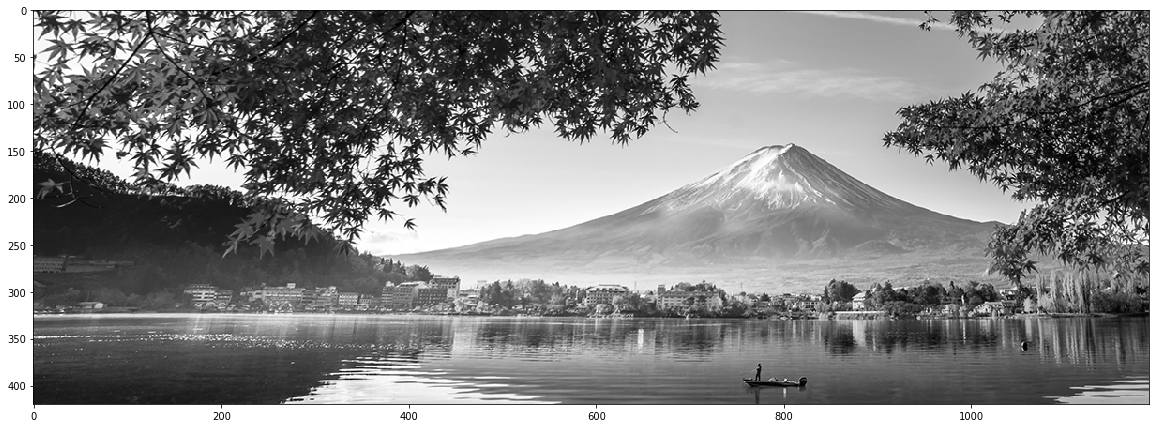

In [7]:
# load grid image
img_sharp = cv2.imread('../220624_SV_3D_Forward/Landscape-Color.jpg',
                      cv2.IMREAD_GRAYSCALE).astype('float32')
img_sharp /= 255.
img_sharp = img_sharp[100:520, :1190] # 400x1000 -> 420x1190 = (6x70)x(17x70)
plt.figure(figsize=(20,20))
plt.imshow(img_sharp, cmap='gray')

img_t = np.stack((img_sharp, img_sharp)) # batch=2
img_t = torch.FloatTensor(img_t).to('cuda')
img_t = img_t.unsqueeze(1) # [2, 400, 1000] -> [2, 1, 400, 1000]
print(img_t.shape)

In [5]:
psf_map_6x17 = np.load('../220624_SV_3D_Forward/psf_2d_6x17_0514_thres270.npy')
print(psf_map_6x17.shape)
psf_map_6x17 = torch.FloatTensor(psf_map_6x17)

(6, 17, 41, 41)


Time: 0.0020020008087158203s
torch.Size([2, 1, 420, 1190])


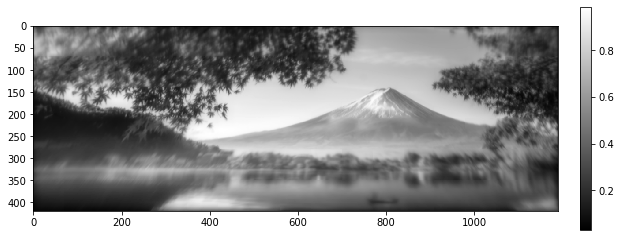

In [9]:
blur_module = SVConv2d_one_channel(kernel_size=41, kH=6, kW=17,initialize=psf_map_6x17).to("cuda")

t0 = time()
img_blur = blur_module(img_t)
print("Time: {}s".format(time()-t0))
print(img_blur.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_blur[0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.colorbar(fraction=0.02, pad=0.04)

In [12]:
# Create Tensors to hold input and outputs.
x = img_t
y = img_blur.detach().cuda()

# Construct our model by instantiating the class defined above
model = SVConv2d_one_channel(kernel_size=21, kH=6, kW=17, initialize=None).to("cuda")

# Construct our loss function and an Optimizer. 
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_list = []

t1 = time()
for t in range(100000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        loss_list.append(loss.item())
        print("epoch: {:^{}d},   loss: {:^{}.4f},   time: {:^{}.1f}s,".format(t+1, 10, loss.item(), 10, time()-t1, 10))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_list)

epoch:    100    ,   loss: 165394.6875,   time:    0.5    s,
epoch:    200    ,   loss: 84745.5000,   time:    1.0    s,
epoch:    300    ,   loss: 45634.0938,   time:    1.4    s,
epoch:    400    ,   loss: 27031.4922,   time:    1.9    s,
epoch:    500    ,   loss: 18244.1641,   time:    2.3    s,
epoch:    600    ,   loss: 14029.2988,   time:    2.8    s,
epoch:    700    ,   loss: 11922.3535,   time:    3.2    s,
epoch:    800    ,   loss: 10790.2227,   time:    3.7    s,
epoch:    900    ,   loss: 10113.8330,   time:    4.2    s,
epoch:    1000   ,   loss: 9654.2285 ,   time:    4.6    s,
epoch:    1100   ,   loss: 9300.5693 ,   time:    5.1    s,
epoch:    1200   ,   loss: 9000.9707 ,   time:    5.5    s,
epoch:    1300   ,   loss: 8730.8984 ,   time:    6.0    s,
epoch:    1400   ,   loss: 8478.6611 ,   time:    6.4    s,
epoch:    1500   ,   loss: 8238.6777 ,   time:    6.9    s,
epoch:    1600   ,   loss: 8008.3071 ,   time:    7.4    s,
epoch:    1700   ,   loss: 7786.2900 , 

KeyboardInterrupt: 

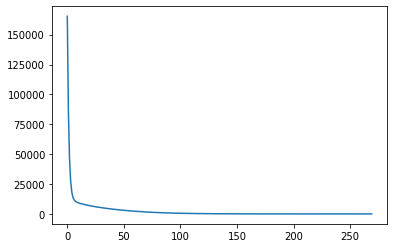

In [13]:
plt.plot(loss_list)

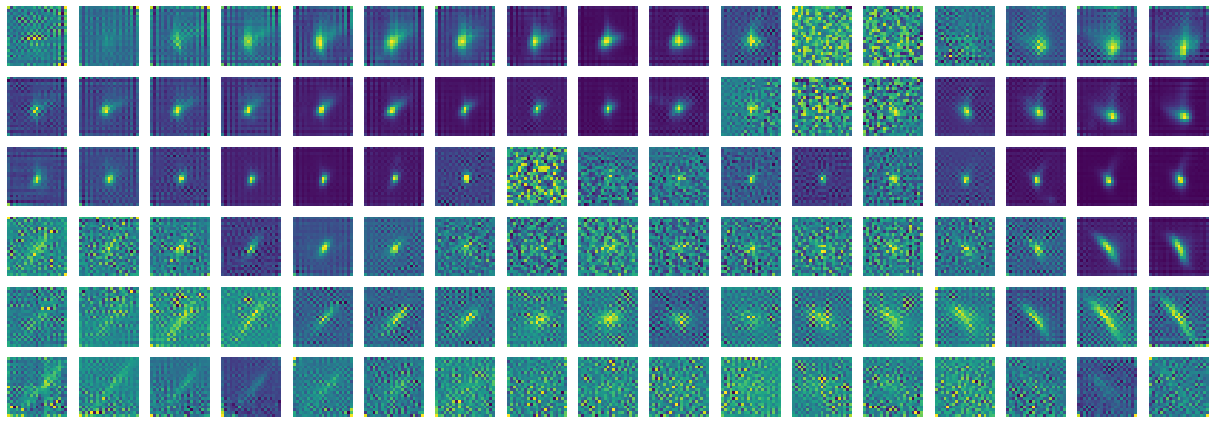

In [16]:
trained_psf = model.SVconv.weight.detach().cpu().numpy().squeeze()
trained_psf = trained_psf.reshape((6,17,21,21))
plot_psf_map(trained_psf)

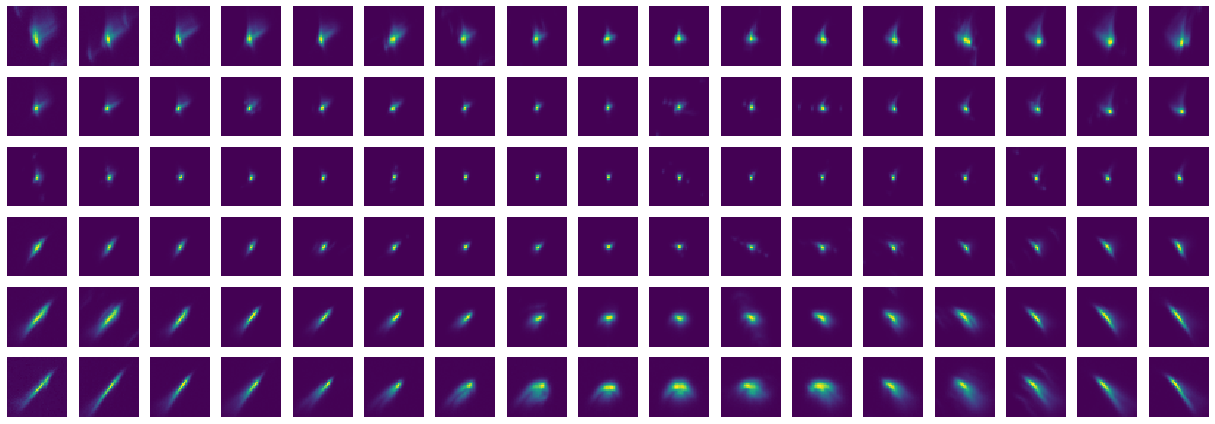

In [17]:
plot_psf_map(psf_map_6x17.detach().cpu().numpy())

In [18]:
np.sum(np.sum(trained_psf, axis=2), axis=2)

array([[0.9630486 , 0.9809442 , 0.9807172 , 0.97339743, 0.98451316,
        0.99034566, 0.99670386, 0.98195726, 0.99627596, 0.990704  ,
        0.9935427 , 0.99069965, 0.9903835 , 0.99580866, 0.9914276 ,
        0.9912093 , 0.98162913],
       [1.0008273 , 1.0055534 , 0.9992277 , 0.9922042 , 0.9985416 ,
        1.0022554 , 0.99902654, 0.99462724, 1.0004271 , 0.99841547,
        0.9987968 , 0.99947864, 0.99941754, 0.9970104 , 0.9952842 ,
        0.9956168 , 0.9954479 ],
       [0.9874    , 0.9835458 , 0.98929846, 0.98748595, 0.99692184,
        0.9946735 , 0.9966545 , 0.99601394, 0.99886954, 0.9986373 ,
        0.9995462 , 0.99918765, 0.99909246, 0.99744296, 0.99037516,
        0.9992967 , 0.9977078 ],
       [0.9904619 , 1.0139221 , 1.0122275 , 1.0058546 , 1.0024252 ,
        0.9938396 , 0.99845946, 0.99888057, 1.0007131 , 1.0012877 ,
        1.0004433 , 1.0007726 , 0.9994498 , 1.0000768 , 0.9953267 ,
        0.9977973 , 0.9935856 ],
       [0.9828766 , 0.99140424, 0.9895093 , 0.990206

## Learn with multiple images

In [30]:
import torch.utils.data as data
import os
import cv2

IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def get_paths_from_images(path):
    '''get image path list from image folder'''
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return sorted(images)


class SharpBlurDataset(data.Dataset):
    '''
    Sharp-Blur pair dataset.
    -Train set  __ Sharp
               |    |- 0001.png
               |    |- 0002.png
               |
               |__ Blur
                    |- 0001.png
                    |- 0002.png
    '''
    def __init__(self, data_path):
        self.path = data_path
        self.Sharp_paths = get_paths_from_images(self.path + "/Sharp")
        self.Blur_paths = get_paths_from_images(self.path + "/Blur")
        
    def __getitem__(self, index):
        S_path = self.Sharp_paths[index]
        B_path = self.Blur_paths[index]
        
        S_img = cv2.imread(S_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.
        B_img = cv2.imread(B_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.
        
        return {'S_img': S_img, 'B_img': B_img, 'S_path': S_path, 'B_path': B_path}
    
    def __len__(self):
        return len(self.Blur_paths)
        

In [28]:
folder_path = "C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur"
print(get_paths_from_images(folder_path + "/Sharp")[:5])
print()
print(get_paths_from_images(folder_path + "/Blur")[:5])

['C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Sharp\\0001.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Sharp\\0002.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Sharp\\0003.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Sharp\\0004.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Sharp\\0005.png']

['C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Blur\\0001.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Blur\\0002.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Blur\\0003.png', 'C:/Users/User/_deconv/2207_DATASETS/_Convolved_Dataset/DIV2K_endcrop_no_noise_6x17_blur/Blur\\0004.png', 'C:/Users/User/_deconv/2207_DATASETS/_

In [37]:
# training stage
import math
train_set = SharpBlurDataset(folder_path)
batch_size = 8

train_size = int(math.ceil(len(train_set) / batch_size))
total_iters = 16000
total_epochs = int(math.ceil(total_iters / train_size))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False,
                                           num_workers=0, pin_memory=True)
print('Number of train images: {:,d}, iters: {:,d}'.format(len(train_set), train_size))
print('Total epochs: ', total_epochs)

Number of train images: 800, iters: 100
Total epochs:  160


In [ ]:
# Construct model
model = SVConv2d_one_channel(kernel_size=21, kH=6, kW=17, initialize=None).to("cuda")

# Construct our loss function and an Optimizer. 
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
t1 = time()
for epoch in range(total_epochs):
    for i, train_data in enumerate(train_loader):
        # print(train_data['B_img'].shape) # torch.Size([8, 420, 1190])
        # print(train_data['B_img'].is_cuda) # False
        B_img_batch = train_data['B_img'].unsqueeze(1).cuda() # [8, 420, 1190] -> [8, 1, 420, 1190]
        S_img_batch = train_data['S_img'].unsqueeze(1).cuda()
        
        # forward pass
        foward_batch = model(S_img_batch)
        
        # Compute loss
        loss = criterion(foward_batch, B_img_batch)
        
        # zero grad, backward pass, weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_list.append(loss.item())
    print("epoch: {:^{}d},   loss: {:^{}.4f},   time: {:^{}.1f}s,".format(epoch+1, 10, loss.item(), 10, time()-t1, 10))



epoch:     1     ,   loss: 484595.4062,   time:    10.0   s,
epoch:     2     ,   loss: 236951.5625,   time:    20.0   s,
epoch:     3     ,   loss: 118942.6094,   time:    30.0   s,
epoch:     4     ,   loss: 63583.4375,   time:    40.1   s,
epoch:     5     ,   loss: 37960.9531,   time:    50.1   s,
epoch:     6     ,   loss: 26307.7598,   time:    60.2   s,
epoch:     7     ,   loss: 21096.5840,   time:    70.2   s,
epoch:     8     ,   loss: 18755.2539,   time:    80.4   s,
epoch:     9     ,   loss: 17635.2070,   time:    90.5   s,
epoch:     10    ,   loss: 17011.7246,   time:   100.6   s,
epoch:     11    ,   loss: 16584.1191,   time:   110.8   s,
epoch:     12    ,   loss: 16234.5371,   time:   120.9   s,
epoch:     13    ,   loss: 15918.9121,   time:   131.0   s,
epoch:     14    ,   loss: 15621.1152,   time:   141.1   s,
epoch:     15    ,   loss: 15334.9844,   time:   151.2   s,
epoch:     16    ,   loss: 15057.7520,   time:   161.3   s,
epoch:     17    ,   loss: 14787.8262